In [1]:
%matplotlib inline
# %matplotlib qt

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PyQt5
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy import fftpack
from scipy.stats import spearmanr

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[['Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

In [4]:
def findPeakIndex(array, minThreshold = 50, widthapart = 50,  twosided = True):
    
    peaks, _ = signal.find_peaks(array, height= minThreshold, distance= widthapart)
    
    if twosided == True:
        peaks_neg, _ = signal.find_peaks(-array, height= minThreshold, distance= widthapart)
        peaks = np.concatenate((peaks, peaks_neg), axis=None)
        peaks = np.sort(peaks, axis=None)
    
    return peaks
        

def rom(list_of_arrays):

    
    reps_max_values = np.array([np.max(array) for array in list_of_arrays])
    reps_min_values = np.array([np.min(array) for array in list_of_arrays])
    
    
    ROM = reps_max_values - reps_min_values
    
    return ROM
    

In [5]:
# Signal Processing

# sampling frequency set to 100 HZ
fsample = 100

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

# Butterworth filter 8-order, 15hz cutoff
fc = 15
w = fc / (fsample/2)
b , a = signal.butter(8, w, btype ='lowpass')

### Reading, Cleaning, and Preprocessing DATA

In [6]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'TNG_PROTRUSION', 'TNG_LAT', 'TNG_NOSE']
Conditions = ['FAST', 'SLOW', 'DIS', 'HOLD', 'NORM']

TASK_DFS_VIDEO_LIST = list()
TASK_DFS_WAVE_LIST = list()

In [7]:
# choose a task to do the analysis on,for example open, spread, pa, bbp, etc
Task = Tasks[1]

In [8]:
path_v = r'/home/deniz/Code/ValidationStudy/01/RSSDK/landmarks_pretrained/AF11_02_NSM_OPEN_1300_landmarksFiltered3D.csv'

In [9]:
# read the data from spreadsheet 
df = pd.read_csv(path_v)
# clean the spreadsheet to the desired df format
df =  df.drop([0]) 
df = cleaning_video_df(df)
# add the tast 
df['Task'] = Task

#df = df.interpolate(method ='cubic', limit_direction ='forward') 

# find the vertical distance 
df = lipDist(df)
# use butterworth filter to smoothen the signal 
df['Vert_Lip_Motion']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
df["Speed"] = np.gradient(df['Vert_Lip_Motion'], df["Time"])
df.head()

,Time,Video_Frame_number,X_LR,Y_LR,Z_LR,X_LLeft,Y_LLeft,Z_LLeft,X_UL,Y_UL,Z_UL,X_LL,Y_LL,Z_LL,Task,Horiz_Lip_Motion,Vert_Lip_Motion,Speed
1,0.000000,0.0,-43.011935,-67.211456,382.000018,5.165011,-109.494707,395.000019,-18.941444,-90.844294,387.000018,-19.039332,-96.396150,389.000018,OPEN,65.405592,5.902095,207.710813
2,0.019105,1.0,-41.773371,22.579493,371.000018,4.838111,24.935700,370.000018,-17.032387,14.266858,360.000017,-17.717836,27.352559,362.000017,OPEN,46.681710,9.870406,178.951953
3,0.038888,2.0,-41.773371,23.185393,371.000018,4.851187,25.608994,371.000018,-17.032387,14.854793,360.000017,-17.717836,27.352559,362.000017,OPEN,46.687507,12.821509,109.741937
4,0.059349,3.0,-41.773371,23.185393,371.000018,4.838111,25.539967,370.000018,-17.032387,14.854793,360.000017,-17.717836,27.943761,362.000017,OPEN,46.681627,14.232500,35.824464
5,0.080485,4.0,-41.660775,23.122899,370.000018,4.851187,25.608994,371.000018,-17.032387,14.854793,360.000017,-17.717836,27.943761,362.000017,OPEN,46.589090,14.266169,-14.936360


In [10]:
tmax = len(df.Time) - 1
tmax_value = df.Time[tmax]
tmin_value = int(df.Time[1])
nsample = fsample*(tmax_value - tmin_value)
print(int(nsample), tmax_value, tmin_value)
tmin_value + (int(nsample)/fsample)

1417 14.175408203125 0


14.17

In [11]:
# sample the time to perfect 100 Hz
# Video Data 
tmax = len(df.Time) - 1
tmax_value = df.Time[tmax]
tmin_value = df.Time[1]
nsample = fsample*(tmax_value - tmin_value)
nsample = int(nsample)
tmax_ideal = tmin_value + (nsample/fsample)
perfect_time = np.linspace(tmin_value, tmax_ideal, num= nsample, endpoint=True)

print(len(perfect_time))
print(len(df["Time"]))

video_df = pd.DataFrame()
video_df['Perf_Time'] = perfect_time
f_motion = interp1d(df['Time'], df['Vert_Lip_Motion'], kind = 'linear')
video_df['Vert_Lip_100'] = f_motion(perfect_time)
# calculate the velocity 
video_df["Speed_100"] = np.gradient(video_df['Vert_Lip_100'], video_df["Perf_Time"])


1417
740


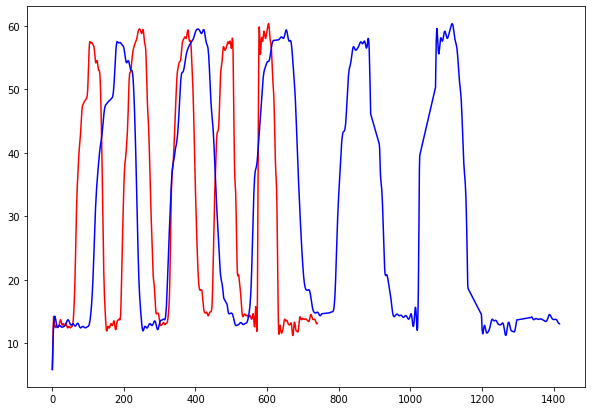

In [12]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df['Vert_Lip_Motion'], 'r')
plt.plot(video_df['Vert_Lip_100'], 'b')


In [13]:
path_w = r'/home/deniz/Code/ValidationStudy/01/WAVE/AF11_01_SBK_20200211_002_NSM_OPEN.tsv'

df_w = pd.read_csv(path_w, delimiter='\t', skiprows=1,header=None)
df_w = cleaning_wave_df(df_w)
df_w['Task'] = Task
df_w = df_w.interpolate(method ='cubic', limit_direction ='forward') 
df_w = lipDist(df_w)
df_w.head()

,Time,FrameID,SensorID,Sensor_1Status,X_Nose,Y_Nose,Z_Nose,SensorID,Sensor_2Status,X_LLeft,...,Y_JR,Z_JR,SensorID,Senson_7Status,X_JL,Y_JL,Z_JL,Task,Horiz_Lip_Motion,Vert_Lip_Motion
0,0.0351,0,0,55,66.947754,-20.777908,-179.57040,2,55,-21.686016,...,-1.207276,-150.14404,7,55,-51.597733,-12.621308,-208.97655,OPEN,57.547748,19.794901
1,0.0451,1,0,55,66.939156,-20.787258,-179.52531,2,55,-21.681715,...,-1.197183,-150.14160,7,55,-51.587730,-12.635316,-208.96072,OPEN,57.488037,19.830563
2,0.0551,2,0,55,66.960960,-20.779926,-179.52843,2,55,-21.687672,...,-1.185942,-150.12849,7,55,-51.551842,-12.623955,-208.94928,OPEN,57.458803,19.812639
3,0.0651,3,0,55,67.025101,-20.814777,-179.56689,2,55,-21.683397,...,-1.182854,-150.11638,7,55,-51.536942,-12.649698,-208.99858,OPEN,57.452568,19.848383
4,0.0751,4,0,55,67.065880,-20.836145,-179.59308,2,55,-21.689299,...,-1.171688,-150.11533,7,55,-51.561623,-12.671506,-208.98132,OPEN,57.472100,19.829796


In [14]:
# sample the time to perfect 100 Hz
# WAVE Data 
tmax = len(df_w.Time) - 1
tmax_value = df_w.Time[tmax]
tmin_value = df_w.Time[1]
nsample = fsample*(tmax_value - tmin_value)
nsample = int(nsample)
tmax_ideal = tmin_value + (nsample/fsample)
perfect_time = np.linspace(tmin_value, tmax_ideal, num= nsample, endpoint=True)

print(len(perfect_time))
print(len(df_w["Time"]))

wave_df = pd.DataFrame()
wave_df['Perf_Time'] = perfect_time
f_motion = interp1d(df_w['Time'], df_w['Vert_Lip_Motion'], kind = 'linear')
wave_df['Vert_Lip_100'] = f_motion(perfect_time)
# calculate the velocity 
wave_df["Speed_100"] = np.gradient(wave_df['Vert_Lip_100'], wave_df["Perf_Time"])



1530
1532


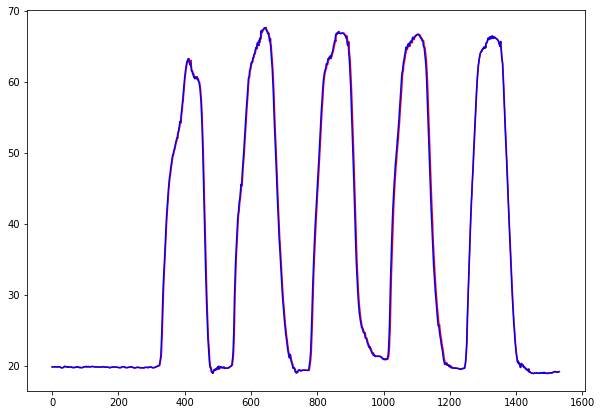

In [15]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df_w['Vert_Lip_Motion'],'r')
plt.plot(wave_df['Vert_Lip_100'], 'b')

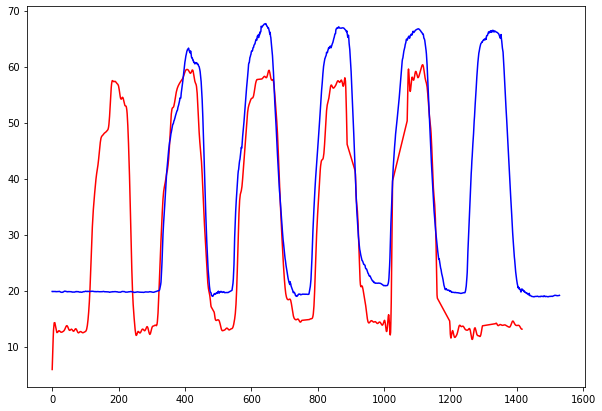

In [16]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100'],'r')
plt.plot(wave_df['Vert_Lip_100'], 'b')

In [17]:
video_df.head()

,Perf_Time,Vert_Lip_100,Speed_100
0,0.000000,5.902095,207.710813
1,0.010007,7.980670,205.051688
2,0.020014,10.006025,175.782361
3,0.030021,11.498800,144.603140
4,0.040028,12.900130,104.498003


The phase shift is:226.09
Video:1417
Video shifted:1642
WAVE:1530
276 1480 1530
1204
1204
The corrolation r and p-value between the signals are: r0.9861948620153143, p0.0



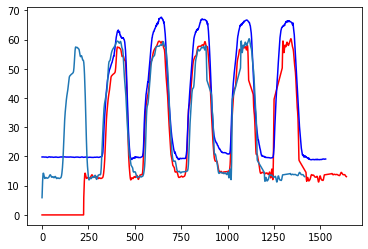

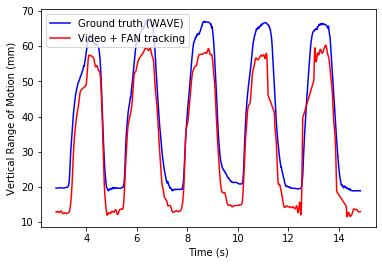

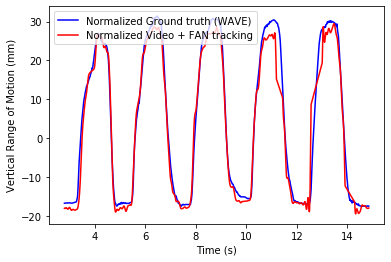

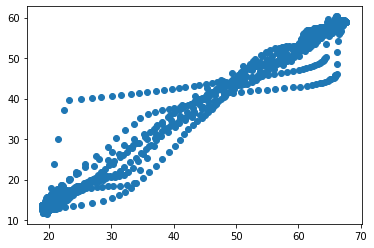

In [18]:

result = pd.DataFrame() 

video_n = sig_norm(video_df['Vert_Lip_100'].values)

wave_n = sig_norm(wave_df['Vert_Lip_100'].values)
#     video_n = video_n[200:-50]
#     wave_n = wave_n[200:-50]


time_w = wave_df['Perf_Time'].values
time_v = video_df['Perf_Time'].values
#     time = time[200:-50]

if len(video_n)<=len(wave_n):
    upper_bound = len(video_n) 
else: 
    upper_bound = len(wave_n) 


s = phase_align(wave_n, video_n, [5,upper_bound])
print('The phase shift is:{}'.format(s))

sp = math.floor(s)


video_shifted = sig_shift(video_df['Vert_Lip_100'],sp)
video_speed_shifted = sig_shift(video_df['Speed_100'],sp)
video_n_s = sig_shift(video_n, sp)
wave = wave_df['Vert_Lip_100'].values
wave_speed = wave_df['Speed_100'].values

upper_bound_shifted = upper_bound + sp -1

if len(wave)< upper_bound_shifted:
    upper_bound_shifted = len(wave)


print('Video:{}'.format(len(video_df['Vert_Lip_100'])))
print('Video shifted:{}'.format(len(video_shifted)))
print('WAVE:{}'.format(len(wave)))
# print('UPPER_BOUND_SHIFTED:{}'.format(upper_bound_shifted))
# print('UPPER_BOUND:{}'.format(upper_bound))


range_l = sp+50
range_u = upper_bound_shifted-50

plt.figure()
plt.plot(video_shifted, 'r')
plt.plot(wave, 'b')
plt.plot(video_df['Vert_Lip_100'].values)


print(range_l,range_u,upper_bound_shifted)

print(len(time_w[range_l:range_u]))
t_u = range_u - range_l 
print(len(time_v[0:t_u]))


result['Time_WAVE'] = time_w[range_l:range_u]
result['Time_VIDEO'] = time_v[0:t_u]
#result['Time'] = time[range_l:range_u]
result['VerDisp_WAVE'] = wave[range_l:range_u]
result['VerDisp_VIDEO'] = video_shifted[range_l:range_u]

#  result['HorDisp_WAVE']
#  result['HorDisp_VIDEO']

result['Speed_WAVE'] = wave_speed[range_l:range_u]
result['Speed_VIDEO'] = video_speed_shifted[range_l:range_u]

name = 'OPEN_ALS1'
cvs = name + '.csv'
result.to_csv(cvs)

plt.figure()

# plt.plot(time[sp:upper_bound_shifted], wave_shifted[sp:upper_bound_shifted],'b', label='Ground truth (WAVE)')
# plt.plot(time[sp:upper_bound_shifted],video_shifted[sp:upper_bound_shifted],'r', label='Video + FAN tracking')
plt.plot(time_w[range_l:range_u], wave[range_l:range_u],'b', label='Ground truth (WAVE)')
plt.plot(time_w[range_l:range_u],video_shifted[range_l:range_u],'r', label='Video + FAN tracking')
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Vertical Range of Motion (mm)')

plt.savefig('{}'.format(name))


plt.figure()
# plt.plot(wave_n[100:upper_bound],'b')
# plt.plot(video_n_s[100:upper_bound],'r')
plt.plot(time_w[range_l:range_u],wave_n[range_l:range_u],'b', label='Normalized Ground truth (WAVE)')
plt.plot(time_w[range_l:range_u],video_n_s[range_l:range_u],'r', label='Normalized Video + FAN tracking')
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Vertical Range of Motion (mm)')
plt.savefig('{}'.format(name+'Normalized'))

plt.figure()
plt.scatter(wave[range_l:range_u], video_shifted[range_l:range_u]) 


r, p = stats.pearsonr(video_n_s[range_l:range_u], wave_n[range_l:range_u])
rms = np.sqrt(np.mean((wave_n[range_l:range_u]-video_n_s[range_l:range_u])**2))

print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
print()


In [19]:
import statistics 
from statistics import mean 
from statistics import stdev 


In [20]:
result.head()

,Time_WAVE,Time_VIDEO,VerDisp_WAVE,VerDisp_VIDEO,Speed_WAVE,Speed_VIDEO
0,2.806905,0.000000,19.675785,12.960058,0.860619,-8.273578
1,2.816912,0.010007,19.689672,12.908311,1.694847,-3.474026
2,2.826918,0.020014,19.709704,12.890528,2.625227,0.662878
3,2.836925,0.030021,19.742211,12.921578,2.094395,4.118485
4,2.846931,0.040028,19.751620,12.972956,0.712504,5.804979


In [21]:
# DO NOT RUN MORE THAN ONCE
parsed_df_2 = pd.DataFrame(columns=['PatientID','FileName','REP','ROM_VIDEO','ROM_WAVE', 'SpdAvg_WAVE', 
                                  'SpdAvg_VIDEO','Disp_WAVE', 'Disp_VIDEO','Time_WAVE', 'Time_VIDEO',
                                  'Speed_WAVE', 'Speed_VIDEO'])


reps = ['R1', 'R2', 'R3', 'R4', 'R5']

In [34]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5']
#reps = ['R1', 'R2', 'R3']

In [23]:
def apnd_adj (d, v, t, i):
    d[i] = d[i].append(d[i+1])
    v[i] = v[i].append(v[i+1])
    t[i] = t[i].append(t[i+1])
    d.pop(i+1)
    v.pop(i+1)
    t.pop(i+1)
    return d, v, t

# START HERE 

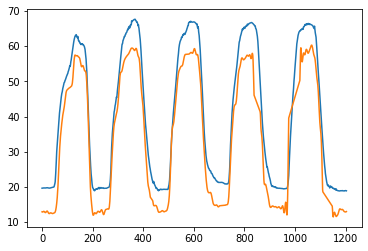

In [24]:
plt.plot(result['VerDisp_WAVE'])
plt.plot(result['VerDisp_VIDEO'])

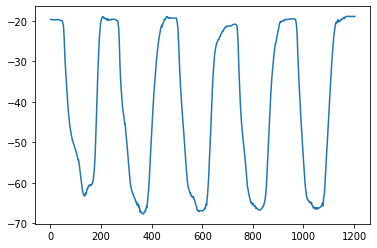

In [25]:
plt.plot(-result['VerDisp_WAVE'])

In [26]:
peaks, _ = signal.find_peaks(-result['VerDisp_WAVE'], height= -32, distance= 100)
print(len(peaks))
print(peaks)

6
[  30  208  461  729  955 1176]


In [27]:
# parse the data for wave and video, displacement and velocity signals

reps_w = np.array_split(result['VerDisp_WAVE'], peaks)
reps_w_v = np.array_split(result['Speed_WAVE'], peaks)
reps_w_t = np.array_split(result['Time_WAVE'], peaks)
reps_v = np.array_split(result['VerDisp_VIDEO'], peaks)
reps_v_v = np.array_split(result['Speed_VIDEO'], peaks)
reps_v_t = np.array_split(result['Time_VIDEO'], peaks)
if 0:
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)

    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)

print(len(reps_w))


7


In [28]:
if 0: 
    reps_w.pop(3)
    reps_w_v.pop(3)
    reps_w_t.pop(3)

    reps_v.pop(3)
    reps_v_v.pop(3)
    reps_v_t.pop(3)
    print(len(reps_v), len(reps_w))


if 1: 
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)
 
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    print(len(reps_v), len(reps_w))
    
if 1: 
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
 
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    print(len(reps_v),len(reps_w))

6 6
5 5


5 5


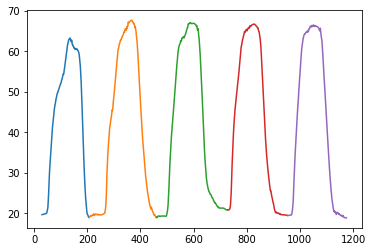

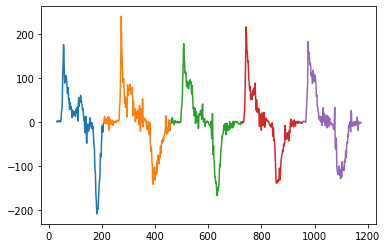

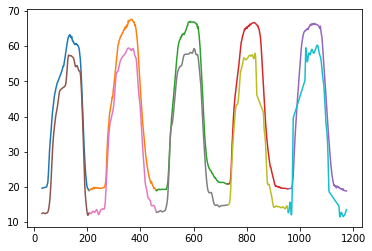

In [29]:
plt.figure()
for i in reps_w:
    plt.plot(i)

plt.figure()
for i in reps_w_v:   
    plt.plot(i)
    
if 0:
    plt.figure()
    for i in reps_v:
        plt.plot(i)
    

plt.figure()
for i in reps_w:
    plt.plot(i)
for i in reps_v:
    plt.plot(i)
print(len(reps_v),len(reps_w))

In [30]:
### CAUTION
#reps_w, reps_w_v, reps_w_t = apnd_adj(reps_w, reps_w_v, reps_w_t, 5)
#reps_v, reps_v_v, reps_v_t = apnd_adj(reps_v, reps_v_v, reps_v_t, 5)



In [31]:
# ROM and AVG speed analysis 

rom_w = rom(reps_w)
rom_v = rom(reps_v)
ave_s_w = np.array([np.mean(abs(rep_v)) for rep_v in reps_w_v])
ave_s_v = np.array([np.mean(abs(rep_v)) for rep_v in reps_v_v])

print(rom_w)
print(rom_v)
print(ave_s_w)
print(ave_s_v)

[44.27273521 48.70641373 48.1176694  47.24261603 47.58619442]
[45.49095973 47.30948059 46.50493932 44.30932109 48.8091941 ]
[49.72738988 39.61829711 35.81423812 41.87550579 44.20759   ]
[51.7835577  38.98363772 34.97814745 41.78391382 53.46872808]


In [35]:
current_df = pd.DataFrame()

current_df['REP'] = reps
current_df['PatientID'] =  'Patient_ALS1'
#current_df['FileName'] = DF['FileName'][1]  
current_df['ROM_WAVE'] = rom_w
current_df['ROM_VIDEO'] = rom_v
current_df['SpdAvg_WAVE'] = ave_s_w
current_df['SpdAvg_VIDEO'] = ave_s_v
current_df['Time_WAVE'] = reps_w_t  
current_df['Time_VIDEO'] = reps_v_t
current_df['Disp_WAVE'] = reps_w  
current_df['Disp_VIDEO'] = reps_v  
current_df['Speed_WAVE'] = reps_w_v 
current_df['Speed_VIDEO'] = reps_v_v


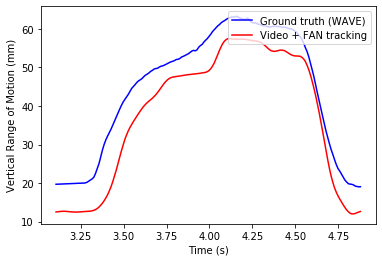

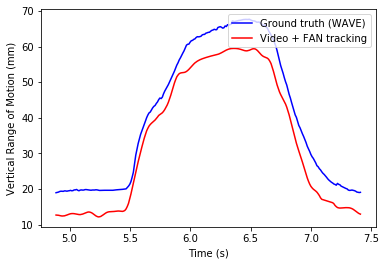

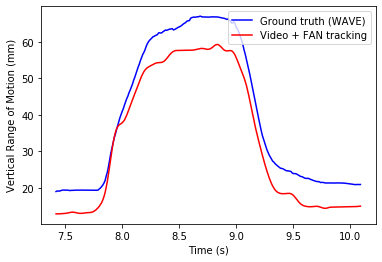

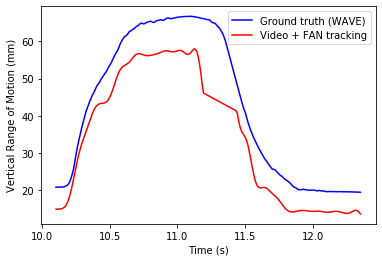

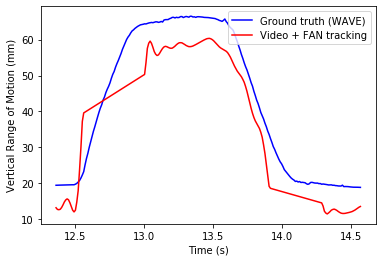

In [41]:
rep_df = current_df
for i in range(len(rep_df)):

    #print(rep_df['FileName'][i] + '_' + rep_df['REP'][i] )
    plt.figure()
    
    plt.plot(rep_df['Time_WAVE'][i].values, rep_df['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( rep_df['Time_WAVE'][i].values,rep_df['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion (mm)')
    plt.savefig('{}'.format('Open_REP_' + rep_df['REP'][i]))

In [42]:
    
print(stats.pearsonr(rep_df['ROM_WAVE'].values, rep_df['ROM_VIDEO'].values))
print(stats.spearmanr(rep_df['ROM_WAVE'].values, rep_df['ROM_VIDEO'].values))
print(stats.spearmanr(rep_df['SpdAvg_WAVE'].values, rep_df['SpdAvg_VIDEO'].values))
print()

(0.42100457088667786, 0.4802455881302729)
SpearmanrResult(correlation=0.6, pvalue=0.28475697986529375)
SpearmanrResult(correlation=0.8999999999999998, pvalue=0.03738607346849874)



In [ ]:
# MAKE SURE TO CHANGE THIS!!!!!!!!!

cvs = 'OPEN_PARSED_ANALYSIS_2.csv'
parsed_df_2.to_csv(cvs)
print(len(parsed_df_2))
print('DONE!')

In [ ]:
for i in range(len(parsed_df_2)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_VIDEO'] = parsed_df_2['Disp_VIDEO'][i]
    rep_df['Speed_VIDEO'] = parsed_df_2['Speed_VIDEO'][i]
    
    
    rep_df['PatientID'] =  parsed_df_2['PatientID'][i]
    rep_df['FileName'] = parsed_df_2['FileName'][i]  

    rep_df['ROM_VIDEO'] = parsed_df_2['ROM_VIDEO'] [i]

    rep_df['SpdAvg_VIDEO'] = parsed_df_2 ['ROM_VIDEO'][i]
    rep_df['Time_WAVE'] = parsed_df_2['Time_WAVE']
    rep_df['Time_VIDEO'] = parsed_df_2['Time_VIDEO']
    name = parsed_df_2['PatientID'][i] + '_' + parsed_df_2['FileName'][i] + '_Video_' +parsed_df_2['REP'][i] 

    cvs = 'Parsed_Data2/OPEN_'+ name +'.csv'
    rep_df.to_csv(cvs)

In [ ]:
for i in range(len(parsed_df_2)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_WAVE'] = parsed_df_2['Disp_WAVE'][i]
    rep_df['Speed_WAVE'] = parsed_df_2['Speed_WAVE'][i]
    
    
    rep_df['PatientID'] =  parsed_df_2['PatientID'][i]
    rep_df['FileName'] = parsed_df_2['FileName'][i]  

    rep_df['ROM_WAVE'] = parsed_df_2['ROM_WAVE'] [i]

    rep_df['SpdAvg_WAVE'] = parsed_df_2 ['ROM_WAVE'][i]
    name = parsed_df_2['PatientID'][i] + '_' + parsed_df_2['FileName'][i] + '_WAVE_' +parsed_df_2['REP'][i] 

    cvs = 'Parsed_Data2/OPEN_'+ name +'.csv'
    rep_df.to_csv(cvs)

In [39]:
    
print(stats.pearsonr(result['ROM_WAVE'].values, result['ROM_VIDEO'].values))
print(stats.spearmanr(result['ROM_WAVE'].values, result['ROM_VIDEO'].values))
print(stats.spearmanr(result['SpdAvg_WAVE'].values, result['SpdAvg_VIDEO'].values))
print()

KeyError: 'ROM_WAVE'

In [ ]:
for i in range(len(rep_df)):

    print(rep_df['FileName'][i] + '_' + rep_df['REP'][i] )
    plt.figure()
    
    plt.plot(rep_df['Time_WAVE'][i].values, rep_df['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( rep_df['Time_VIDEO'][i].values,rep_df['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion (mm)')
    plt.savefig('{}'.format('Open_REP_' + rep_df['REP'][i]))

In [ ]:

print(len(parsed_df_2))
#parsed_df_2.head(10)

In [ ]:
deniz = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'DJ']
mk = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'MK']
rm = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'RM']


In [ ]:

#stats.pearsonr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values)
    
print(stats.pearsonr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values))
print(stats.spearmanr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values))
print(stats.spearmanr(deniz['SpdAvg_WAVE'].values, deniz['SpdAvg_VIDEO'].values))
print()
#print(stats.pearsonr(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values))
print(stats.spearmanr(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values))
print(stats.spearmanr(mk['SpdAvg_WAVE'].values, mk['SpdAvg_VIDEO'].values))
print()
#print(stats.pearsonr(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values))
print(stats.spearmanr(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values))
print(stats.spearmanr(rm['SpdAvg_WAVE'].values, rm['SpdAvg_VIDEO'].values))
print()

print(stats.spearmanr(parsed_df_2['ROM_WAVE'].values, parsed_df_2['ROM_VIDEO'].values))
print(stats.spearmanr(parsed_df_2['SpdAvg_WAVE'].values, parsed_df_2['SpdAvg_VIDEO'].values))
print()

In [ ]:
plt.figure()
plt.scatter(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values, label='Participant 1')


plt.scatter(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values, label='Participant 2')

plt.scatter(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values, label='Participant 3')

plt.legend(loc="upper left")
plt.xlabel('Vertical Range of Motion, EMA-Ground truth (mm)')
plt.ylabel('Vertical Range of Motion, Video + FAN (mm)')
plt.savefig('{}'.format('OPEN_REP_CORR'))

In [ ]:
for i in range(len(deniz)):

    print(deniz['FileName'][i] + '_' + deniz['REP'][i] )
    plt.figure()
    
    plt.plot(deniz['Time_WAVE'][i].values, deniz['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( deniz['Time_VIDEO'][i].values,deniz['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion (mm)')
    plt.savefig('{}'.format('Open_REP_' + deniz['REP'][i]))

In [ ]:
plt.figure()
plt.scatter(deniz['SpdAvg_WAVE'].values, deniz['SpdAvg_VIDEO'].values, label='Participant 1')


plt.scatter(mk['SpdAvg_WAVE'].values, mk['SpdAvg_VIDEO'].values, label='Participant 2')

plt.scatter(rm['SpdAvg_WAVE'].values, rm['SpdAvg_VIDEO'].values, label='Participant 3')

plt.legend(loc="upper left")
plt.xlabel('Average Vertical Speed, EMA-Ground truth (mm/s)')
plt.ylabel('Average Vertical Speed, Video + FAN (mm/s)')
plt.savefig('{}'.format('OPEN_REP_CORR_V'))

In [ ]:
deniz.loc[deniz['FileName'] == 'OPEN_NORM', 'color'] = 1
deniz.loc[deniz['FileName'] == 'OPEN_HOLD', 'color']=2
deniz.loc[deniz['FileName'] == 'OPEN_FAST', 'color']=3
deniz.loc[deniz['FileName'] == 'OPEN_DIS', 'color']=4

In [ ]:
from matplotlib.colors import ListedColormap
colours = ListedColormap(['r','b','g','y'])
classes = ['OPEN_NORM', 'OPEN_HOLD', 'OPEN_FAST', 'OPEN_DIS']
scatter = plt.scatter(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values, c =deniz['color'].values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.legend(loc="upper left")

plt.xlabel('Vertical Range of Motion, Ground truth (WAVE)')
plt.ylabel('Vertical Range of Motion, Video + FAN tracking')
plt.savefig('{}'.format('OPEN_REP_CORR_DENIZ'))

In [ ]:
mk.loc[mk['FileName'] == 'OPEN_NORM', 'color'] = 1
mk.loc[mk['FileName'] == 'OPEN_HOLD', 'color']=2
mk.loc[mk['FileName'] == 'OPEN_FAST', 'color']=3
mk.loc[mk['FileName'] == 'OPEN_DIS', 'color']=4

In [ ]:
from matplotlib.colors import ListedColormap
colours = ListedColormap(['r','b','g','y'])
classes = ['OPEN_NORM', 'OPEN_HOLD', 'OPEN_FAST', 'OPEN_DIS']
scatter = plt.scatter(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values, c =mk['color'].values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [ ]:
print(deniz['ROM_WAVE'].values)
print(deniz['ROM_VIDEO'].values)
print(deniz['FileName'].values)

In [ ]:
for df in Final_DFS_LIST:
    print(df['PatientID'][1])

In [ ]:
parsed_df.head(40)

In [ ]:
for df in Final_DFS_LIST:
    peaks, _ = signal.find_peaks(array, height= minThreshold, distance= widthapart)
    #ROM_V, V_max, V_min = rom(df['Vert_Lip_Motion'].values, peaks)
    
    
    print(df['Condition'][1])
    print(ROM_V, V_max, V_min)
    
    reps_rom_list = 
    

In [ ]:
if 0:
    video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[11]['Vert_Lip_Motion'])
    wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[9]['Vert_Lip_Motion'])

    upper_bound = len(video_n) - 10
    upper_bound2 = len(wave_n) - 10

    s = phase_align(wave_n[600:1100], video_n, [10,upper_bound])
    print('The phase shift is:{}'.format(s))

    sp = math.ceil(s) + 600


    video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[11]['Vert_Lip_Motion'],sp)

    if len(video_shifted) <= len(wave_n):
        signal_bound = upper_bound + sp
    else: 
        signal_bound = len(wave_n) - 10 

    print()
    plt.figure()

    plt.plot(TASK_DFS_WAVE_100HZ_LIST[9]['Vert_Lip_Motion'],'b')
    plt.plot(TASK_DFS_VIDEO_100HZ_LIST[11]['Vert_Lip_Motion'],'r')

    if 0: 
        plt.figure()
        a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[6]['Time'])
        plt.plot(a, 'b')
        b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[4]['Time'])
        plt.plot(b, 'r')
        plt.figure()
        plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
        plt.plot(video_shifted,'r')

        plt.figure()
        plt.scatter(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'][sp:signal_bound], 
                    video_shifted[sp:signal_bound])

        

In [ ]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5']


In [ ]:
parsed_df = pd.DataFrame(columns=['PatientID','FileName','REP','Disp_WAVE','Disp_VIDEO','ROM_WAVE','ROM_VIDEO','Speed_WAVE', 'Speed_VIDEO'])

In [ ]:
for df in Final_DFS_LIST:
    current_df['REP'] = reps
    current_df['PatientID'] =  df['PatientID'][1]
    current_df['FileName'] = df['FileName'][1]
    parsed_df = parsed_df.append(current_df,ignore_index=True)